# Image classification from fMRI data

In this notebook, we implement an LSTM model to identify the category of the image a person is looking at from their brain activitis.

Dataset is from BOLD5000 project. In this data set, images from COCO, ImageNet, and Scene UNdrstanding are shown to 4 particpants as shown in Table 1 below. Imagenet and COCO categories are shown in Tabeles 2 and 3. All Scene UNderstanding images will be under 'scene' category.

<img src="misc/image_count_tables.png">


For the classification task, we will:
* Create 3 super category lables for our data: Animal, Artifact, Scene.
* Load ROI voxel time series activities from all the particpants.
* Shuffle and split the ROI activities into train and dev set.
* Create the LSTM model.
* Use hyper parameter search to tune our model.
* Train the final model and use it to generate confusion matrix.


# Import the packages

In [1]:
import time
import os
import json
import pickle
import math
import h5py
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
import re
import collections

import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, VGG19
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from matplotlib.pyplot import imread, imshow

# custom functions
from losses import weighted_crossentropy_loss

%matplotlib inline
%load_ext autoreload
%autoreload 1

SEED=1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed

K.clear_session()



# Label the data

We have a list of image names shown to each participant from BOLD5000 data set. Using the image name, we can lookup the super category it belongs to in *super_categories.txt files. The *super_categories.txt files are created by hand using wordnet and COCO super category labels.



In [2]:

# Regex used to identify the image name and its subcategory.
# Imagenet filename example: n01692333_12353.JPEG
# COCO filename example: COCO_train2014_000000523236.jpg 
imageNetRegex = re.compile(r'^(n.*?)_.*?\.JPEG$')
cocoRegex = re.compile(r'^COCO_train2014_0+(.*?).jpg$')

# Imagenet supercategory file was created looking up the image descriptions in wordnet
imagenet_label_dict = {}
with open('labelImages/imagenet_super_categories.txt', 'r') as f:
    for line in f.readlines():
        contents = line.strip().split(' ')
        imagenet_label_dict[contents[0]] = contents[1]

# COCO supercategory file was created using COCO dataset 94 super categories.
coco_cat_lookup = {}
with open('labelImages/coco_super_categories.txt', 'r') as f:
    for line in f.readlines():
        contents = line.strip().split(' ')
        coco_cat_lookup[contents[0]] = contents[1]

# BOLD5000 file providing COCO image category IDs and descriptions.
with open('labelImages/coco_final_annotations.pkl', 'rb') as f:
    cocoLabels = pickle.load(f)


coco_label_dict = {}
for image_id, contents in cocoLabels.items():
    category = str(contents[0].get('category_id'))
    coco_label_dict[str(image_id)] = coco_cat_lookup.get(category)


global_label_lookup = {key: value for key, value in imagenet_label_dict.items()}
global_label_lookup.update(coco_label_dict)

# Experiment with 5 super categories
#mega_categories_lookup = {'artifact': 'artifact', 'animal': 'animal', 'food': 'food', 'plant': None, 'scene': 'scene', 'communication': None,
#'person': 'person', 'vehicle': None, 'furniture': None, 'kitchen': 'food', 'sports': 'person', 'indoor': None, 'electronic': None, 'accessory': None,
#'outdoor': 'scene', 'appliance': None}
#classes = {'animal': 0, 'artifact': 1, 'scene': 2, 'person': 3, 'food': 4}

# Experiment with 3 super categories
mega_categories_lookup = {'artifact': 'artifact', 'animal': 'animal', 'food': None, 'plant': None, 'scene': 'scene', 'communication': None,
'person': None, 'vehicle': None, 'furniture': None, 'kitchen': None, 'sports': None, 'indoor': None, 'electronic': None, 'accessory': None,
'outdoor': 'scene', 'appliance': None}
classes = {'animal': 0, 'artifact': 1, 'scene': 2}

# load stimuli list
subject_labels = {'CSI1': [], 'CSI2': [], 'CSI3': [], 'CSI4': []}
subject_mega_labels_count = {'CSI1': None, 'CSI2': None, 'CSI3': None, 'CSI4': None}

subject_persource_image_count = {'CSI1': None, 'CSI2': None, 'CSI3': None, 'CSI4': None}
subject_persource_label_count = {'CSI1': None, 'CSI2': None, 'CSI3': None, 'CSI4': None}

# For each subject, we go through image names shown to the particpant and look up the super category.
# Using supercategory we create the final labels.
for subject in subject_labels.keys():
    imageNetCount = 0
    cocoCount = 0
    sceneCount = 0
    imageNetCategoriesCount = collections.Counter()
    cocoNetCategoriesCount = collections.Counter()
    globalCategoriesCount = collections.Counter()

    with open('labelImages/stim_lists/%s_stim_lists.txt' % subject, 'r') as f:
        stimuli_list = f.read().splitlines()
        for imageFileName in stimuli_list:
            match = imageNetRegex.match(imageFileName)
            if match:
                imageLabel = match.group(1)
                category = imagenet_label_dict.get(imageLabel, None)
                if not category:
                    print("could not find category for image: %s" % imageFileName)
                    continue

                imageNetCategoriesCount.update([category])
                megaCat = mega_categories_lookup.get(category)
                if megaCat:
                    globalCategoriesCount.update([megaCat])

                imageNetCount += 1
                classNum = classes.get(megaCat, -1)
                subject_labels[subject].append(classNum)
                continue

            match = cocoRegex.match(imageFileName)
            if match:
                imageLabel = match.group(1)
                category = coco_label_dict.get(imageLabel)
                #if 'outdoor' in category:
                #
                #     print(imageFileName)

                if not category:
                    print("could not find category for image: %s" % imageFileName)
                    continue

                cocoNetCategoriesCount.update([category])
                megaCat = mega_categories_lookup.get(category)
                if megaCat:
                    globalCategoriesCount.update([megaCat])

                cocoCount += 1
                classNum = classes.get(megaCat, -1)
                subject_labels[subject].append(classNum)

                continue

            globalCategoriesCount.update(['scene'])
            sceneCount += 1
            classNum = classes.get('scene', -1)
            subject_labels[subject].append(classNum)

    assert sum(imageNetCategoriesCount.values()) == imageNetCount
    assert sum(cocoNetCategoriesCount.values()) == cocoCount
    subject_persource_image_count[subject] = [imageNetCount, cocoCount, sceneCount]
    subject_persource_label_count[subject] = [imageNetCategoriesCount, cocoNetCategoriesCount, sceneCount]
    subject_mega_labels_count[subject] = globalCategoriesCount

#print(subject_persource_image_count)
#for subject, counterList in subject_persource_label_count.items():
#    for counter in counterList:
#        print(counter)

#for subject, counter in subject_mega_labels_count.items():
#    print(counter)
#for subject, label_list in subject_labels.items():
    # print(label_list)
    #print(sum(label_list))
    #print(sum([val for val in label_list if val != -1]))
    #print(len([val for val in label_list if val == -1]))

subject_labels_mask = {'CSI1': [], 'CSI2': [], 'CSI3': [], 'CSI4': []}
subject_categorical_labels = {'CSI1': [], 'CSI2': [], 'CSI3': [], 'CSI4': []}
# Create masks for data labeled as -1
for subject, labels_list in subject_labels.items():
    labels_array = np.asarray(labels_list)
    masked_labels = labels_array != -1
    subject_labels_mask[subject] = masked_labels
    subject_categorical_labels[subject] = utils.to_categorical(labels_array[masked_labels])

#print(subject_categorical_labels)
print("Super categories used for labels: %s" % classes)
for subject, subjLabels in subject_categorical_labels.items():
    print("subject: %s labels shape:%s " % (subject, str(subjLabels.shape)))

Super categories used for labels: {'animal': 0, 'artifact': 1, 'scene': 2}
subject: CSI1 labels shape:(3661, 3) 
subject: CSI2 labels shape:(3661, 3) 
subject: CSI3 labels shape:(3661, 3) 
subject: CSI4 labels shape:(2153, 3) 


# Loading fMRI data

Instead of training on raw fMRI data, we load activities from 10 regions of interest (ROI) in brain's visual cortex.

Higher level visual regions:
RHPPA, LHPPA, RHRSC, LHRSC, RHOPA, LHOPA

Lower level visual regions:
RHEarlyVis, LHEarlyVis

The preprocessed data has different number of voxels for each participant ROI. Also for the same participant the number of voxels change from one region to another. To concatenate all participants' ROIs, We decided to pad all the ROI activities to the same length mathcing the biggest ROI vector (696 voxels).


In [5]:

# Individual's maximim ROI vector sizes
#subject_ax_length = {'CSI1': 285, 'CSI2': 561, 'CSI3': 696, 'CSI4': 455}

# Used to pad all ROI vectors to the same length. 
subject_ax_length = {'CSI1': 696, 'CSI2': 696, 'CSI3': 696, 'CSI4': 696}
subject_datasets = {'CSI1': None, 'CSI2': None, 'CSI3': None, 'CSI4': None}

boldRoiFolder = os.path.join('/home', 'ubuntu', 'boldroi', 'ROIs')

# Go through all particpants, load ROI vectors
for subject in subject_datasets.keys():
    tr_list = []
    ax_length = subject_ax_length[subject]
    for TR in ['TR1','TR2','TR3','TR4','TR5']:
        roi_list = []
        for roi in ['RHPPA', 'LHPPA', 'RHRSC', 'LHRSC', 'RHOPA', 'LHOPA', 'LHLOC', 'RHLOC', 'RHEarlyVis', 'LHEarlyVis']:
            hFile = os.path.join(boldRoiFolder, subject, 'h5', '%s_ROIs_%s.h5' % (subject, TR))
            with h5py.File(hFile, 'r') as f: 
                print('subject: %s tr: %s roi: %s' % (subject, TR, roi))
                x_roi = list(f[roi])
                x_r = np.stack(x_roi, axis=0)
                # mask only the vectors corresponding to the labeled images
                x_r = x_r[subject_labels_mask[subject], :]
                print(x_r.shape)
                x_r = np.pad(x_r, ((0, 0), (0, ax_length-x_r.shape[1])), mode='constant', constant_values=0)
                roi_list.append(x_r)

        tr_list.append(roi_list)

    xtr_list = []
    for tr_num, rlist in enumerate(tr_list):
        xa = np.hstack(rlist)
        xtr_list.append(xa)
        #print(xa.shape)

    x_all = np.stack(xtr_list, axis=1)
    print("time series ROI data shape: %s" % str(x_all.shape))
    subject_datasets[subject] = x_all
    del x_all

subject: CSI1 tr: TR1 roi: RHPPA
(3661, 200)
subject: CSI1 tr: TR1 roi: LHPPA
(3661, 131)
subject: CSI1 tr: TR1 roi: RHRSC
(3661, 143)
subject: CSI1 tr: TR1 roi: LHRSC
(3661, 86)
subject: CSI1 tr: TR1 roi: RHOPA
(3661, 187)
subject: CSI1 tr: TR1 roi: LHOPA
(3661, 101)
subject: CSI1 tr: TR1 roi: LHLOC
(3661, 152)
subject: CSI1 tr: TR1 roi: RHLOC
(3661, 190)
subject: CSI1 tr: TR1 roi: RHEarlyVis
(3661, 285)
subject: CSI1 tr: TR1 roi: LHEarlyVis
(3661, 210)
subject: CSI1 tr: TR2 roi: RHPPA
(3661, 200)
subject: CSI1 tr: TR2 roi: LHPPA
(3661, 131)
subject: CSI1 tr: TR2 roi: RHRSC
(3661, 143)
subject: CSI1 tr: TR2 roi: LHRSC
(3661, 86)
subject: CSI1 tr: TR2 roi: RHOPA
(3661, 187)
subject: CSI1 tr: TR2 roi: LHOPA
(3661, 101)
subject: CSI1 tr: TR2 roi: LHLOC
(3661, 152)
subject: CSI1 tr: TR2 roi: RHLOC
(3661, 190)
subject: CSI1 tr: TR2 roi: RHEarlyVis
(3661, 285)
subject: CSI1 tr: TR2 roi: LHEarlyVis
(3661, 210)
subject: CSI1 tr: TR3 roi: RHPPA
(3661, 200)
subject: CSI1 tr: TR3 roi: LHPPA
(366

(2153, 455)
subject: CSI4 tr: TR3 roi: RHLOC
(2153, 417)
subject: CSI4 tr: TR3 roi: RHEarlyVis
(2153, 356)
subject: CSI4 tr: TR3 roi: LHEarlyVis
(2153, 408)
subject: CSI4 tr: TR4 roi: RHPPA
(2153, 187)
subject: CSI4 tr: TR4 roi: LHPPA
(2153, 157)
subject: CSI4 tr: TR4 roi: RHRSC
(2153, 142)
subject: CSI4 tr: TR4 roi: LHRSC
(2153, 51)
subject: CSI4 tr: TR4 roi: RHOPA
(2153, 335)
subject: CSI4 tr: TR4 roi: LHOPA
(2153, 279)
subject: CSI4 tr: TR4 roi: LHLOC
(2153, 455)
subject: CSI4 tr: TR4 roi: RHLOC
(2153, 417)
subject: CSI4 tr: TR4 roi: RHEarlyVis
(2153, 356)
subject: CSI4 tr: TR4 roi: LHEarlyVis
(2153, 408)
subject: CSI4 tr: TR5 roi: RHPPA
(2153, 187)
subject: CSI4 tr: TR5 roi: LHPPA
(2153, 157)
subject: CSI4 tr: TR5 roi: RHRSC
(2153, 142)
subject: CSI4 tr: TR5 roi: LHRSC
(2153, 51)
subject: CSI4 tr: TR5 roi: RHOPA
(2153, 335)
subject: CSI4 tr: TR5 roi: LHOPA
(2153, 279)
subject: CSI4 tr: TR5 roi: LHLOC
(2153, 455)
subject: CSI4 tr: TR5 roi: RHLOC
(2153, 417)
subject: CSI4 tr: TR5 roi

Save ROI activities on file (only run once)

In [ ]:

with open('roi_all', 'wb') as f:
    pickle.dump(subject_datasets, f)


Load ROI activites (if already saved on file)

In [ ]:
with open('roi_all', 'rb') as f:
    subject_datasets = pickle.load(f)

# Choose the data set to train on 

Here we chose the particpant and ROI regions to train on.
For the final model we trained on all particpants and all ROI regions. Data for other experiments were alse provided in the paper.

In [6]:
#del x_all
#x_all = subject_datasets['CSI4']
#labels_all = subject_categorical_labels['CSI4']

roi_list_all = []
labels_list_all = []
for subject in ['CSI1', 'CSI2', 'CSI3', 'CSI4']:
    roi_list_all.append(subject_datasets[subject])
    labels_list_all.append(subject_categorical_labels[subject])

#VCs = 4176 #1392 # 2784 #4176 #6960
#x_all = np.concatenate(roi_list_all)[:,:, :VCs]
x_all = np.concatenate(roi_list_all)
labels_all = np.concatenate(labels_list_all)
print("fMRI ROI data shape: %s" % str(x_all.shape))
print("Image labels shape: %s" % str(labels_all.shape))


fMRI ROI data shape: (13136, 5, 6960)
Image labels shape: (13136, 3)


# Shuffle and split the data into train and dev set.
Given the subjects' physiological trains influeces the fMRI data, data distribution is not uniform across particpants and we need to shuffle the data to help model learn from all the distributions.
Given our small data set, we split the data into 80-20% train-dev set to have an accurate distribution of data in both train and dev sets.  

In [7]:

# Split data into train/test set
num_samples = x_all.shape[0]
div = int(num_samples * 0.8)
x_shuffle, y_shuffle = shuffle(x_all, labels_all, random_state=0)
x_train = x_shuffle[0:div, :]
y_train = y_shuffle[0:div]
x_test = x_shuffle[div:, :]
y_test = y_shuffle[div:]

print("x train shape: %s" % str(x_train.shape))
print("y train shape: %s" % str(y_train.shape))
print("x test shape: %s" % str(x_test.shape))
print("y test shape: %s" % str(y_test.shape))



x train shape: (10508, 5, 6960)
y train shape: (10508, 3)
x test shape: (2628, 5, 6960)
y test shape: (2628, 3)


# Create Model

Model Architecture is x_input -> LSTM (with input and recurrent drouput) -> Dense -> Relu Activation -> Softmax layer -> Prediction 

<img src="misc/model_architecture.png" style="width:500px">


In [9]:

X_input = Input(shape=(x_train.shape[1], x_train.shape[2]))
#X = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(X_input)
#X = TimeDistributed(Dense(32, activation='relu'))(X_input)
X = LSTM(12, dropout=0.49, recurrent_dropout=0.55)(X_input)
#X = LSTM(64)(X_input)
#X = Bidirectional(LSTM(64))(X_input)
X = Dense(32, activation='relu')(X)
#X = Dropout(0.2)(X)
predictions = Dense(labels_all.shape[1], activation='softmax')(X)
classifier_model = Model(inputs=X_input, outputs=predictions)
classifier_model.summary()


W1208 17:47:09.968100 140260004976384 nn_ops.py:4283] Large dropout rate: 0.55 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 6960)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                334704    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                416       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 335,219
Trainable params: 335,219
Non-trainable params: 0
_________________________________________________________________


# Train the model

For final training, we used mini-batch gradient descent with the Adam optimizer. Our validation loss reaches minimum in less that 30 epochs. To prevent overfitting, we use early stopping callback.

Hyper parameter values are obtained from the hyper parameter seach later in this notebook.


In [10]:
# Train setttings
i=1 
callbacks = [TensorBoard(log_dir=f'./log/{i}'), EarlyStopping(monitor='val_loss', mode='min')]
epochs = 50
batch_size = 208

In [11]:

#sgd = optimizers.SGD(lr=0.005, decay=1e-3, momentum=0.9, nesterov=True)
adam = optimizers.Adam(learning_rate=0.0016, decay=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)

#classifier_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
#classifier_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#classifier_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
wlosss = weighted_crossentropy_loss(np.array([1.16,1.41,1.]))
classifier_model.compile(optimizer=adam, loss=wlosss, metrics=['accuracy'])

train_history = classifier_model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks, validation_data=(x_test, y_test))
classifier_model.save('lstm_classifier_%s.h5' % i)


Train on 10508 samples, validate on 2628 samples
Epoch 1/50
10508/10508 [==============================] - 8s 747us/sample - loss: 1.2250 - accuracy: 0.5206 - val_loss: 1.1164 - val_accuracy: 0.5772
Epoch 2/50
10508/10508 [==============================] - 6s 558us/sample - loss: 1.0492 - accuracy: 0.6027 - val_loss: 1.0028 - val_accuracy: 0.6172
Epoch 3/50
10508/10508 [==============================] - 6s 570us/sample - loss: 0.9691 - accuracy: 0.6407 - val_loss: 0.9674 - val_accuracy: 0.6286
Epoch 4/50
10508/10508 [==============================] - 6s 544us/sample - loss: 0.9254 - accuracy: 0.6631 - val_loss: 0.9438 - val_accuracy: 0.6560
Epoch 5/50
10508/10508 [==============================] - 6s 539us/sample - loss: 0.8980 - accuracy: 0.6801 - val_loss: 0.9309 - val_accuracy: 0.6511
Epoch 6/50
10508/10508 [==============================] - 6s 539us/sample - loss: 0.8732 - accuracy: 0.6903 - val_loss: 0.9226 - val_accuracy: 0.6587
Epoch 7/50
10508/10508 [===========================

# Hyperparameter search

We randomly sample a learning rate (log scale), recurrent dropout rate, input dropout rate, batch size, and number of LSTM hidden units (log scale) in each iteration. The results for each iteration is saved in tuning.txt file.

In [ ]:

# for each loop choose a learning_rate (log scale), batch_size, dropout
learning_rate_range = [0.0001, 0.2] # log scale
recurrent_dropout_range = [0, 0.65] # uniform random
input_dropout_range = [0, 0.65] # uniform random
batch_size_range = [32, 256] # uniform random
lstm_hidden_units_range = [4, 1028] # log scale

epochs=50

min_log_scale = learning_rate_range[0]
max_log_scale = learning_rate_range[1]

max_seed_lr = round(-1 * math.log(min_log_scale, 10), 2)
min_seed_lr = round(-1 * math.log(max_log_scale, 10), 2)

min_seed_lr = round(math.log(lstm_hidden_units_range[0], 10), 2)
max_seed_lr = round(math.log(lstm_hidden_units_range[1], 10), 2)

for i in range(0, 100):
    callbacks = [TensorBoard(log_dir=f'./log/{i}'), EarlyStopping(monitor='val_loss', mode='min')]
    lr_seed  = random.uniform(min_seed_lr, max_seed_lr)
    lr = round(10**(-1. * lr_seed), 6)
    recurrent_dropout = round(random.uniform(recurrent_dropout_range[0], recurrent_dropout_range[1]), 2)
    input_dropout = round(random.uniform(input_dropout_range[0], input_dropout_range[1]), 2)
    batch_size = random.randint(batch_size_range[0], batch_size_range[1])
    units_seed = random.uniform(min_seed_lr, max_seed_lr)
    lstm_hidden_units = int(10 ** units_seed)
    print("----------------i: %s lr: %s input dropout: %s recurrent dropout: %s batch_size: %s lstm_hidden_units: %s" %
          (i, lr, input_dropout, recurrent_dropout, batch_size, lstm_hidden_units))
    X_input = Input(shape=(x_train.shape[1], x_train.shape[2]))
    X = LSTM(lstm_hidden_units, dropout=input_dropout, recurrent_dropout=recurrent_dropout)(X_input)
    X = Dense(32, activation='relu')(X)
    predictions = Dense(labels_all.shape[1], activation='softmax')(X)
    classifier_model = Model(inputs=X_input, outputs=predictions)
    adam = optimizers.Adam(learning_rate=lr, decay=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)
    classifier_model.compile(optimizer=adam, loss=weighted_categorical_crossentropy(np.array([1.16,1.41,1.])), metrics=['accuracy'])
    train_history = classifier_model.fit(x=x_train, y=y_train, epochs=epochs, batch_size= batch_size, callbacks=callbacks, validation_data=(x_test, y_test))
    with open("tuning.txt", "a") as myfile:
        myfile.write("%s %s %s %s %s %s %s \n" % (lr, input_dropout, recurrent_dropout, batch_size, lstm_hidden_units,
                                         round(train_history.history['val_loss'][-1], 3),
                                         round(train_history.history['val_accuracy'][-1], 3)))

    del classifier_model




# Generating confusion matrix

The code in this section uses scikit learn confusion matrix.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


In [14]:
# Load model for performance analysis
#i = 1
#model = load_model('lstm_classifier_%s.h5' % i)
model = classifier_model

In [15]:
y_pred = model.predict(x_test)
y_true=np.argmax(y_test, axis=1)
print(y_true.shape)

y_results=np.argmax(y_pred, axis=1)
print(y_results.shape)

(2628,)
(2628,)


In [16]:
#classes = {'animal': 0, 'artifact': 1, 'scene': 2, 'person': 3, 'food': 4}
#class_names = ['animal', 'artifact', 'scene', 'person', 'food']
classes = {'animal': 0, 'artifact': 1, 'scene': 2}
class_names = ['animal', 'artifact', 'scene']


In [22]:
# borrowed from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization
[[698 103  52]
 [193 396 145]
 [147 265 629]]
Normalized confusion matrix
[[0.82 0.12 0.06]
 [0.26 0.54 0.2 ]
 [0.14 0.25 0.6 ]]


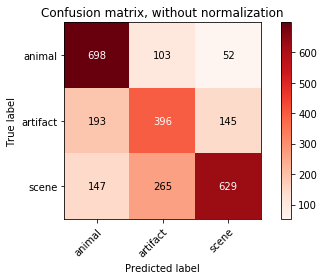

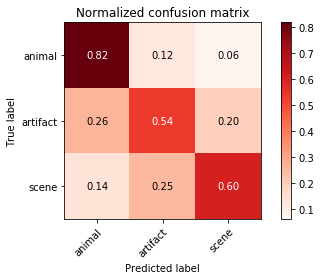

In [23]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_results, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_results, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

## 